In [36]:
import os
import re
from statistics import mode

from PIL import Image
import numpy as np
import pandas
import torch
from torchvision import transforms

In [37]:
# df = pandas.read_json("./data/train.json")  # question, answerを持つDataFrame
# df.head()

In [38]:
# df[:3].to_json("./data/train_EXP.json")

In [39]:
df = pandas.read_json("./data/train_EXP.json")  # question, answerを持つDataFrame
df.head()

,image,question,answers
0,train_00000.jpg,What is this?,"[{'answer_confidence': 'yes', 'answer': 'beef ..."
1,train_00001.jpg,maybe it's because you're pushing it down instead,"[{'answer_confidence': 'yes', 'answer': 'unans..."
2,train_00002.jpg,What color is this item?,"[{'answer_confidence': 'yes', 'answer': 'grey'..."


In [40]:
def process_text(text):
    # lowercase
    text = text.lower()

    # 数詞を数字に変換
    num_word_to_digit = {
        'zero': '0', 'one': '1', 'two': '2', 'three': '3', 'four': '4',
        'five': '5', 'six': '6', 'seven': '7', 'eight': '8', 'nine': '9',
        'ten': '10'
    }
    for word, digit in num_word_to_digit.items():
        text = text.replace(word, digit)

    # 小数点のピリオドを削除
    text = re.sub(r'(?<!\d)\.(?!\d)', '', text)

    # 冠詞の削除
    text = re.sub(r'\b(a|an|the)\b', '', text)

    # 短縮形のカンマの追加
    contractions = {
        "dont": "don't", "isnt": "isn't", "arent": "aren't", "wont": "won't",
        "cant": "can't", "wouldnt": "wouldn't", "couldnt": "couldn't"
    }
    for contraction, correct in contractions.items():
        text = text.replace(contraction, correct)

    # 句読点をスペースに変換
    text = re.sub(r"[^\w\s':]", ' ', text)

    # 句読点をスペースに変換
    text = re.sub(r'\s+,', ',', text)

    # 連続するスペースを1つに変換
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [41]:
class VQADataset(torch.utils.data.Dataset):
    def __init__(self, df_path, image_dir, transform=None, answer=True):
        self.transform = transform  # 画像の前処理
        self.image_dir = image_dir  # 画像ファイルのディレクトリ
        self.df = pandas.read_json(df_path)  # 画像ファイルのパス，question, answerを持つDataFrame
        self.answer = answer

        # question / answerの辞書を作成
        self.question2idx = {}
        self.answer2idx = {}
        self.idx2question = {}
        self.idx2answer = {}

        # 質問文に含まれる単語を辞書に追加
        for question in self.df["question"]:
            question = process_text(question)
            words = question.split(" ")
            for word in words:
                if word not in self.question2idx:
                    self.question2idx[word] = len(self.question2idx)
        self.idx2question = {v: k for k, v in self.question2idx.items()}  # 逆変換用の辞書(question)

        if self.answer:
            # 回答に含まれる単語を辞書に追加
            for answers in self.df["answers"]:
                for answer in answers:
                    word = answer["answer"]
                    word = process_text(word)
                    if word not in self.answer2idx:
                        self.answer2idx[word] = len(self.answer2idx)
            self.idx2answer = {v: k for k, v in self.answer2idx.items()}  # 逆変換用の辞書(answer)

    def update_dict(self, dataset):
        """
        検証用データ，テストデータの辞書を訓練データの辞書に更新する．

        Parameters
        ----------
        dataset : Dataset
            訓練データのDataset
        """
        self.question2idx = dataset.question2idx
        self.answer2idx = dataset.answer2idx
        self.idx2question = dataset.idx2question
        self.idx2answer = dataset.idx2answer

    def __getitem__(self, idx):
        """
        対応するidxのデータ（画像，質問，回答）を取得．

        Parameters
        ----------
        idx : int
            取得するデータのインデックス

        Returns
        -------
        image : torch.Tensor  (C, H, W)
            画像データ
        question : torch.Tensor  (vocab_size)
            質問文をone-hot表現に変換したもの
        answers : torch.Tensor  (n_answer)
            10人の回答者の回答のid
        mode_answer_idx : torch.Tensor  (1)
            10人の回答者の回答の中で最頻値の回答のid
        """
        image = Image.open(f"{self.image_dir}/{self.df['image'][idx]}")
        image = self.transform(image)
        question = np.zeros(len(self.idx2question) + 1)  # 未知語用の要素を追加
        # question_words = self.df["question"][idx].split(" ")
        question_words = process_text(self.df["question"][idx]).split(" ") # 質問文の前処理
        for word in question_words:
            try:
                question[self.question2idx[word]] = 1  # one-hot表現に変換
            except KeyError:
                question[-1] = 1  # 未知語

        if self.answer:
            answers = [self.answer2idx[process_text(answer["answer"])] for answer in self.df["answers"][idx]]
            mode_answer_idx = mode(answers)  # 最頻値を取得（正解ラベル）

            return image, torch.Tensor(question), torch.Tensor(answers), int(mode_answer_idx)

        else:
            return image, torch.Tensor(question)

    def __len__(self):
        return len(self.df)

In [42]:
# dataloader / model
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = VQADataset(df_path="./data/train_EXP.json", image_dir="./data/train", transform=transform)
# test_dataset = VQADataset(df_path="./data/valid.json", image_dir="./data/valid", transform=transform, answer=False)
# test_dataset.update_dict(train_dataset)

In [43]:
# num_workers を指定すると遅くなった挙句にエラーになる
# num_workers = os.cpu_count()
# num_workers = 1
# print(num_workers)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False,
#                         # num_workers=num_workers,
#                         # persistent_workers=(os.name == 'nt'),
#                         # pin_memory=True
#                     )
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, persistent_workers=(os.name == 'nt'))
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, persistent_workers=(os.name == 'nt'))

In [44]:
for image, question, answers, mode_answer in train_loader:
    print(image.size(), question.size(), answers.size(), mode_answer.size())
    break
# torch.Size([1, 3, 224, 224]) torch.Size([1, 14]) torch.Size([1, 10]) torch.Size([1])
# torch.Size([3, 3, 224, 224]) torch.Size([3, 14]) torch.Size([3, 10]) torch.Size([3])
# [batch_size, channel, height, width] [batch_size, vocab_size] [batch_size, n_answer] [batch_size]

torch.Size([1, 3, 224, 224]) torch.Size([1, 14]) torch.Size([1, 10]) torch.Size([1])


In [45]:
# # dataの取り出し
# tmp = train_loader.__iter__()
# image, question, answers, mode_answer = tmp.next() 
# print(image.size(), question.size(), answers.size(), mode_answer.size())

In [46]:
idx = 0

In [47]:
_answers = answers[idx].detach().numpy()
print(answers[idx])
print(_answers)

tensor([0., 0., 0., 0., 1., 0., 2., 1., 0., 0.])
[0. 0. 0. 0. 1. 0. 2. 1. 0. 0.]


In [48]:
from pprint import pprint

# print(df['answers'][idx])
pprint(df['answers'][idx])

[{'answer': 'beef chuck steak', 'answer_confidence': 'yes'},
 {'answer': 'beef chuck steak', 'answer_confidence': 'yes'},
 {'answer': 'beef chuck steak', 'answer_confidence': 'yes'},
 {'answer': 'beef chuck steak', 'answer_confidence': 'yes'},
 {'answer': 'flat iron beef chuck steak', 'answer_confidence': 'yes'},
 {'answer': 'beef chuck steak', 'answer_confidence': 'yes'},
 {'answer': 'steak', 'answer_confidence': 'yes'},
 {'answer': 'flat iron beef chuck steak', 'answer_confidence': 'yes'},
 {'answer': 'beef chuck steak', 'answer_confidence': 'yes'},
 {'answer': 'beef chuck steak', 'answer_confidence': 'yes'}]


In [49]:
_mode_answers = mode_answer[idx].detach().numpy()
print(mode_answer[idx])
print(_mode_answers)

tensor(0)
0


In [50]:
_qustion = question[idx].detach().numpy()
print(question[idx])
print(_qustion)

tensor([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [51]:
print(df['question'][idx])

What is this?


In [52]:
import matplotlib.pyplot as plt

(3, 224, 224)
150528
<class 'numpy.ndarray'>


(-0.5, 223.5, 223.5, -0.5)

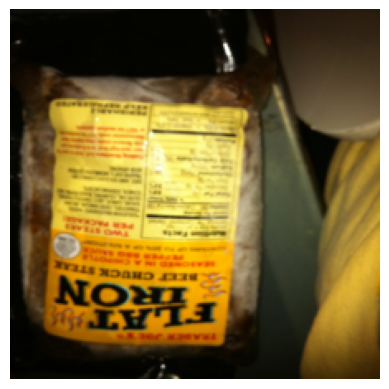

In [53]:
_image = image[idx].detach().numpy()
print(_image.shape)
print(_image.size)
print(type(_image))

fig, ax = plt.subplots()
ax.imshow(np.transpose(_image, (1, 2, 0)))
ax.axis('off')
# plt.show()

(968, 1296)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


(-0.5, 967.5, 1295.5, -0.5)

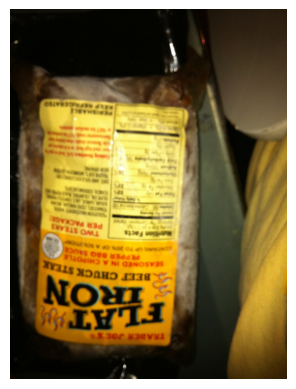

In [54]:
image_dir="./data/train"
_image = Image.open(f"{image_dir}/{df['image'][idx]}")
# print(_image.shape) # error
print(_image.size)
print(type(_image))

fig, ax = plt.subplots()
ax.imshow(_image)
ax.axis('off')
# ax.set_title(f'{question}')
# plt.show()

NVIDIA LAMB optimizerを使用する方法

- [NVIDIAでLAMBなどを使用する方法](https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587)
- [PythonのNVIDIA/apexがwindowsインストールできなかったのでメモ](https://note.com/kurogane_himaki/n/n5e8116954786)
- [【せっかち用】invalid command 'bdist_wheel' の対応方法](https://zenn.dev/ihcomirot/articles/2b054378779445)

In [55]:
# from gensim.models import word2vec
# pip install gensim
# pip install scipy==1.12

In [56]:
from transformers import BertTokenizer, BertModel

In [57]:
# BERTの日本語モデル
# MODEL_NAME = 'cl-tohoku/bert-base-japanese-whole-word-masking'
# BERTの英語モデル
MODEL_NAME = 'bert-base-uncased'

#トークナイザとモデルのロード
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertModel.from_pretrained(MODEL_NAME)

text = 'what is this'
tokenized_text = tokenizer.tokenize(text)
tokenized_text.insert(0, "[CLS]")
tokenized_text.append("[SEP]")
print(tokenized_text)
# model_output = model(tokenized_text)
# print(model_output)

['[CLS]', 'what', 'is', 'this', '[SEP]']


In [58]:
import torch

model = BertModel.from_pretrained(MODEL_NAME)
# model = model.cuda()

def get_embedding(text):
    tokens = tokenizer(text, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**tokens)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

embedding = get_embedding(text)
print(embedding.shape)
print(embedding)

(768,)
[ 3.48340496e-02 -7.69418254e-02 -2.96215471e-02 -2.53321469e-01
  3.23072188e-02 -1.92334816e-01 -3.05886026e-02  3.81107986e-01
 -2.53836811e-01 -3.42316717e-01  1.78451482e-02 -4.68976498e-01
 -3.72093081e-01  6.28604293e-01 -3.14186662e-01  1.04628846e-01
  2.27756709e-01 -5.11579998e-02  5.63182542e-03  4.25803900e-01
 -1.07455015e-01  3.39351952e-01 -4.44540650e-01  1.23872899e-01
  3.14482212e-01  3.56344998e-01 -3.63940209e-01 -7.71258473e-02
  1.60198566e-02 -2.27971077e-01  3.99843037e-01  8.78291801e-02
 -3.94535542e-01 -3.24566811e-01 -2.06307977e-01  4.66284305e-02
 -1.36060148e-01 -2.25882366e-01 -3.94315124e-01  2.01453894e-01
 -7.96079516e-01 -1.02977015e-01 -4.98367921e-02  1.07958578e-01
 -2.42428944e-01 -5.10461390e-01  1.47225887e-01 -2.23988146e-01
 -7.30170131e-01  2.15507179e-01 -2.81222612e-01  2.84965098e-01
  4.76966836e-02  1.36296511e-01 -2.31230780e-01  2.65681833e-01
  3.00861411e-02 -4.99635696e-01  9.32442304e-03  2.82781683e-02
  3.79157454e-01  

In [59]:
class BertWrapper:
    def __init__(self, model_name_or_path='bert-base-uncased', device=None):
        # BERTの日本語モデル: 'cl-tohoku/bert-base-japanese-whole-word-masking'
        # BERTの英語モデル: 'bert-base-uncased'
        self.tokenizer = BertTokenizer.from_pretrained(model_name_or_path)
        self.model = BertModel.from_pretrained(model_name_or_path)
        self.model.eval()

        # if device is None:
        #     device = "cuda" if torch.cuda.is_available() else "cpu"
        # self.device = torch.device(device)
        # self.model.to(device)

    def get_embedding(self, text):
        tokens = self.tokenizer(text, return_tensors='pt')
        with torch.no_grad():
            outputs = self.model(**tokens)
        return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

In [60]:
bert_wrapper = BertWrapper()
embedding = bert_wrapper.get_embedding(text)
print(embedding.shape)
print(embedding)

(768,)
[ 3.48340496e-02 -7.69418254e-02 -2.96215471e-02 -2.53321469e-01
  3.23072188e-02 -1.92334816e-01 -3.05886026e-02  3.81107986e-01
 -2.53836811e-01 -3.42316717e-01  1.78451482e-02 -4.68976498e-01
 -3.72093081e-01  6.28604293e-01 -3.14186662e-01  1.04628846e-01
  2.27756709e-01 -5.11579998e-02  5.63182542e-03  4.25803900e-01
 -1.07455015e-01  3.39351952e-01 -4.44540650e-01  1.23872899e-01
  3.14482212e-01  3.56344998e-01 -3.63940209e-01 -7.71258473e-02
  1.60198566e-02 -2.27971077e-01  3.99843037e-01  8.78291801e-02
 -3.94535542e-01 -3.24566811e-01 -2.06307977e-01  4.66284305e-02
 -1.36060148e-01 -2.25882366e-01 -3.94315124e-01  2.01453894e-01
 -7.96079516e-01 -1.02977015e-01 -4.98367921e-02  1.07958578e-01
 -2.42428944e-01 -5.10461390e-01  1.47225887e-01 -2.23988146e-01
 -7.30170131e-01  2.15507179e-01 -2.81222612e-01  2.84965098e-01
  4.76966836e-02  1.36296511e-01 -2.31230780e-01  2.65681833e-01
  3.00861411e-02 -4.99635696e-01  9.32442304e-03  2.82781683e-02
  3.79157454e-01  

In [61]:
class SentenceBert:
    def __init__(self, model_name_or_path, device=None):
        self.tokenizer = BertTokenizer.from_pretrained(model_name_or_path)
        self.model = BertModel.from_pretrained(model_name_or_path)
        self.model.eval()

        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = torch.device(device)
        self.model.to(device)

    def _mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0] #First element of model_output contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    @torch.no_grad()
    def encode(self, sentences, batch_size=8):
        all_embeddings = []
        iterator = range(0, len(sentences), batch_size)
        for batch_idx in iterator:
            batch = sentences[batch_idx:batch_idx + batch_size]

            encoded_input = self.tokenizer.batch_encode_plus(batch, padding="longest", 
                                           truncation=True, return_tensors="pt").to(self.device)
            model_output = self.model(**encoded_input)
            sentence_embeddings = self._mean_pooling(model_output, encoded_input["attention_mask"]).to('cpu')

            all_embeddings.extend(sentence_embeddings)

        # return torch.stack(all_embeddings).numpy()
        return torch.stack(all_embeddings)


In [62]:
modelX = SentenceBert(MODEL_NAME)
sentence_vectors = modelX.encode([text])[0]
print(sentence_vectors.size())
print(sentence_vectors)

torch.Size([768])
tensor([ 3.4834e-02, -7.6942e-02, -2.9622e-02, -2.5332e-01,  3.2307e-02,
        -1.9233e-01, -3.0589e-02,  3.8111e-01, -2.5384e-01, -3.4232e-01,
         1.7845e-02, -4.6898e-01, -3.7209e-01,  6.2860e-01, -3.1419e-01,
         1.0463e-01,  2.2776e-01, -5.1158e-02,  5.6324e-03,  4.2580e-01,
        -1.0746e-01,  3.3935e-01, -4.4454e-01,  1.2387e-01,  3.1448e-01,
         3.5634e-01, -3.6394e-01, -7.7126e-02,  1.6019e-02, -2.2797e-01,
         3.9984e-01,  8.7829e-02, -3.9453e-01, -3.2457e-01, -2.0631e-01,
         4.6629e-02, -1.3606e-01, -2.2588e-01, -3.9431e-01,  2.0145e-01,
        -7.9608e-01, -1.0298e-01, -4.9837e-02,  1.0796e-01, -2.4243e-01,
        -5.1046e-01,  1.4723e-01, -2.2399e-01, -7.3017e-01,  2.1551e-01,
        -2.8122e-01,  2.8497e-01,  4.7697e-02,  1.3630e-01, -2.3123e-01,
         2.6568e-01,  3.0086e-02, -4.9964e-01,  9.3246e-03,  2.8278e-02,
         3.7916e-01,  4.3832e-02,  3.3043e-01, -3.7299e-01,  1.2567e-01,
         4.4701e-01,  1.4691e-01,

d:\Documents\Works\PythonWorks\dl_lecture_competition_pub\.venv_VQA-competition\lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [65]:
class VQADatasetX(torch.utils.data.Dataset):
    def __init__(self, df_path, image_dir, transform=None, answer=True):
        self.transform = transform  # 画像の前処理
        self.image_dir = image_dir  # 画像ファイルのディレクトリ
        self.df = pandas.read_json(df_path)  # 画像ファイルのパス，question, answerを持つDataFrame
        self.answer = answer
        self.word2vec = None
        # self.bart = SentenceBert(MODEL_NAME)
        self.bart = BertWrapper()

        # question / answerの辞書を作成
        self.question2idx = {}
        self.answer2idx = {}
        self.idx2question = {}
        self.idx2answer = {}
        self.sample_sentence = []

        # 質問文に含まれる単語を辞書に追加
        for question in self.df["question"]:
            question = process_text(question)
            words = question.split(" ")
            self.sample_sentence.append(question)
            # print(words)
            for word in words:
                if word not in self.question2idx:
                    self.question2idx[word] = len(self.question2idx)
        self.idx2question = {v: k for k, v in self.question2idx.items()}  # 逆変換用の辞書(question)
        print(self.sample_sentence)

        if self.answer:
            # 回答に含まれる単語を辞書に追加
            for answers in self.df["answers"]:
                for answer in answers:
                    word = answer["answer"]
                    word = process_text(word)
                    if word not in self.answer2idx:
                        self.answer2idx[word] = len(self.answer2idx)
            self.idx2answer = {v: k for k, v in self.answer2idx.items()}  # 逆変換用の辞書(answer)

    def update_dict(self, dataset):
        """
        検証用データ，テストデータの辞書を訓練データの辞書に更新する．

        Parameters
        ----------
        dataset : Dataset
            訓練データのDataset
        """
        self.question2idx = dataset.question2idx
        self.answer2idx = dataset.answer2idx
        self.idx2question = dataset.idx2question
        self.idx2answer = dataset.idx2answer

    def __getitem__(self, idx):
        """
        対応するidxのデータ（画像，質問，回答）を取得．

        Parameters
        ----------
        idx : int
            取得するデータのインデックス

        Returns
        -------
        image : torch.Tensor  (C, H, W)
            画像データ
        question : torch.Tensor  (vocab_size)
            質問文をone-hot表現に変換したもの
        answers : torch.Tensor  (n_answer)
            10人の回答者の回答のid
        mode_answer_idx : torch.Tensor  (1)
            10人の回答者の回答の中で最頻値の回答のid
        """
        image = Image.open(f"{self.image_dir}/{self.df['image'][idx]}")
        image = self.transform(image)
        # question = np.zeros(len(self.idx2question) + 1)  # 未知語用の要素を追加
        # # question_words = self.df["question"][idx].split(" ")
        question_words = process_text(self.df["question"][idx]).split(" ") # 質問文の前処理
        # for word in question_words:
        #     try:
        #         question[self.question2idx[word]] = 1  # one-hot表現に変換
        #     except KeyError:
        #         question[-1] = 1  # 未知語
        print(process_text(self.df["question"][idx]))
        # question = self.bart.encode([process_text(self.df["question"][idx])])[0]
        question = self.bart.get_embedding([process_text(self.df["question"][idx])])
        print(question)

        if self.answer:
            answers = [self.answer2idx[process_text(answer["answer"])] for answer in self.df["answers"][idx]]
            mode_answer_idx = mode(answers)  # 最頻値を取得（正解ラベル）

            return image, torch.Tensor(question), torch.Tensor(answers), int(mode_answer_idx)

        else:
            return image, torch.Tensor(question)

    def __len__(self):
        return len(self.df)

In [66]:
train_datasetX = VQADatasetX(df_path="./data/train_EXP.json", image_dir="./data/train", transform=transform)

['what is this', "maybe it's because you're pushing it down instead", 'what color is this item']


In [67]:
train_loaderX = torch.utils.data.DataLoader(train_datasetX, batch_size=1, shuffle=False)

In [68]:
# torch.Size([1, 3, 224, 224]) torch.Size([1, 14]) torch.Size([1, 10]) torch.Size([1])
# torch.Size([3, 3, 224, 224]) torch.Size([3, 14]) torch.Size([3, 10]) torch.Size([3])
# [batch_size, channel, height, width] [batch_size, vocab_size] [batch_size, n_answer] [batch_size]

In [69]:
for image, question, answers, mode_answer in train_loaderX:
    print(image.size(), question.size(), answers.size(), mode_answer.size())
    break

what is this
[ 3.48340496e-02 -7.69418254e-02 -2.96215471e-02 -2.53321469e-01
  3.23072188e-02 -1.92334816e-01 -3.05886026e-02  3.81107986e-01
 -2.53836811e-01 -3.42316717e-01  1.78451482e-02 -4.68976498e-01
 -3.72093081e-01  6.28604293e-01 -3.14186662e-01  1.04628846e-01
  2.27756709e-01 -5.11579998e-02  5.63182542e-03  4.25803900e-01
 -1.07455015e-01  3.39351952e-01 -4.44540650e-01  1.23872899e-01
  3.14482212e-01  3.56344998e-01 -3.63940209e-01 -7.71258473e-02
  1.60198566e-02 -2.27971077e-01  3.99843037e-01  8.78291801e-02
 -3.94535542e-01 -3.24566811e-01 -2.06307977e-01  4.66284305e-02
 -1.36060148e-01 -2.25882366e-01 -3.94315124e-01  2.01453894e-01
 -7.96079516e-01 -1.02977015e-01 -4.98367921e-02  1.07958578e-01
 -2.42428944e-01 -5.10461390e-01  1.47225887e-01 -2.23988146e-01
 -7.30170131e-01  2.15507179e-01 -2.81222612e-01  2.84965098e-01
  4.76966836e-02  1.36296511e-01 -2.31230780e-01  2.65681833e-01
  3.00861411e-02 -4.99635696e-01  9.32442304e-03  2.82781683e-02
  3.79157454

In [70]:
_qustion = question[idx].detach().numpy()
print(question[idx].size())
print(question[idx])
print(_qustion)

torch.Size([768])
tensor([ 3.4834e-02, -7.6942e-02, -2.9622e-02, -2.5332e-01,  3.2307e-02,
        -1.9233e-01, -3.0589e-02,  3.8111e-01, -2.5384e-01, -3.4232e-01,
         1.7845e-02, -4.6898e-01, -3.7209e-01,  6.2860e-01, -3.1419e-01,
         1.0463e-01,  2.2776e-01, -5.1158e-02,  5.6318e-03,  4.2580e-01,
        -1.0746e-01,  3.3935e-01, -4.4454e-01,  1.2387e-01,  3.1448e-01,
         3.5634e-01, -3.6394e-01, -7.7126e-02,  1.6020e-02, -2.2797e-01,
         3.9984e-01,  8.7829e-02, -3.9454e-01, -3.2457e-01, -2.0631e-01,
         4.6628e-02, -1.3606e-01, -2.2588e-01, -3.9432e-01,  2.0145e-01,
        -7.9608e-01, -1.0298e-01, -4.9837e-02,  1.0796e-01, -2.4243e-01,
        -5.1046e-01,  1.4723e-01, -2.2399e-01, -7.3017e-01,  2.1551e-01,
        -2.8122e-01,  2.8497e-01,  4.7697e-02,  1.3630e-01, -2.3123e-01,
         2.6568e-01,  3.0086e-02, -4.9964e-01,  9.3244e-03,  2.8278e-02,
         3.7916e-01,  4.3831e-02,  3.3043e-01, -3.7299e-01,  1.2567e-01,
         4.4701e-01,  1.4691e-01,